In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/precip_env/share/proj'
import cartopy.crs as ccrs
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import pyart
from tint import Cell_tracks
from tint.grid_utils import get_grid_size as ggs
import gc
from matplotlib import pyplot as plt
import itertools
from scipy import interpolate


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from pyart.core import geographic_to_cartesian_aeqd

In [3]:
def _nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def interp_lonlat(lon, lat, data, radar_lon, radar_lat, grid_x, grid_y):
    x, y = geographic_to_cartesian_aeqd(lon, lat, radar_lon, radar_lat)

    target_x, target_y = np.meshgrid(grid_x['data'], grid_y['data'])
    points = list(zip(x.flatten(), y.flatten()))
    values = data.flatten()
    interp_data = interpolate.griddata(points, values, (target_x, target_y))
    interp_data = np.ma.masked_where(np.isnan(interp_data), interp_data)
    interp_data = np.tile(interp_data, (2, 1, 1))
    interp_data = interp_data[np.newaxis, :, :, :]
    return interp_data

In [4]:
def get_grid(filename):
    print('Gridding... ' + filename)
    
    nc = netcdf_dataset(filename)
    
    sat_height = nc.variables['goes_imager_projection'].perspective_point_height
    radar_lon = -98.128
    radar_lat = 36.741

    _x = nc.variables['x'] * sat_height
    _y = nc.variables['y'] * sat_height
    _c = nc.variables['CMI_C13'][:] * -1
    data = nc.variables['CMI_C13']
    
    proj_var = nc.variables[data.grid_mapping]
    
    globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.semi_major_axis,
                       semiminor_axis=proj_var.semi_minor_axis)
    
    proj = ccrs.Geostationary(central_longitude=-75,sweep_axis='x',
                              satellite_height=sat_height, globe = globe)
    
    trans = ccrs.PlateCarree(central_longitude=0)
    
    transform_xy = trans.transform_points(proj, _x, _y)
    
    lim = [_nearest(transform_xy[:,0],-103),_nearest(transform_xy[:,0],-92)
            ,_nearest(transform_xy[:,1],42),_nearest(transform_xy[:,1],30)]
    
    
    x = _x[lim[0]:lim[1]]
    y = _y[lim[2]:lim[3]]
    
    c = _c[lim[2]:lim[3],lim[0]:lim[1]]
        
    x_mesh, y_mesh = np.meshgrid(x, y)
    
    lonlat = trans.transform_points(proj, x_mesh, y_mesh)
    lons = lonlat[:, :, 0]
    lats = lonlat[:, :, 1]
    
    interp_c = interp_lonlat(lons, lats, c,
                             radar_lon, radar_lat, grid_x, grid_y) 
    
    _time = {'calendar': 'gregorian','data': np.array([ 0.934]),
            'long_name': 'Time of grid', 'standard_name': 'time',
            'units': str('seconds since ' + nc.time_coverage_end)}
    
#    _fields = {'reflectivity': {'_FillValue': -9999.0, 'data': np.ma.masked_array(c, mask= False),
#                       'long_name': 'reflectivity',
#                       'standard_name': 'equivalent_reflectivity_factor',
#                       'units': 'dBZ', 'valid_max': c.max(), 'valid_min': c.min()}}
    
    _fields = {'c13': {'_FillValue': -9999.0,
                                'data': interp_c,
               'long_name': 'channel 13 10.3 microns K',
               'standard_name': 'c13',
               'units': 'K', 'valid_max': c.max(), 'valid_min': c.min()}}
    
    _metadata = {'Conventions': '', 'comment': '',
                'history': '', 'institution': '', 'instrument_name': '',
                'original_container': 'NEXRAD Level II', 'references': '',
                'source': '', 'title': '', 'vcp_pattern': '', 'version': ''}
    
    _origin_latitude = {'data': np.array([0]),
                       'long_name': 'Latitude at grid origin',
                       'standard_name': 'latitude',
                       'units': 'degrees_north', 'valid_max': 90.0,
                       'valid_min': -90.0}
    
#    _origin_longitude = {'data': np.ma.array([radar_lon]), 
#                        'long_name': 'Longitude at grid origin', 
#                        'standard_name': 'longitude', 'units': 'degrees_east', 
#                        'valid_max': 180.0, 'valid_min': -180.0}
#    
#    _origin_altitude = {'data': np.ma.masked_array(np.array([0]), mask= False), 
#                       'long_name': 'Altitude at grid origin', 
#                       'standard_name': 'altitude', 'units': 'm'}
    
    _x = {'axis': 'X', 'data': grid_x['data'], 
          'long_name': 'X distance on the projection plane from the origin', 
          'standard_name': 'projection_x_coordinate', 'units': 'm'}
    
    _y = {'axis': 'Y', 'data': grid_y['data'], 
          'long_name': 'Y distance on the projection plane from the origin', 
          'standard_name': 'projection_x_coordinate', 'units': 'm'}
    
    _z = {'axis': 'Z', 'data': np.array([0, mesh_size]),
          'long_name': 'Z distance on the projection plane from the origin',
          'positive': 'up', 'standard_name': 'projection_z_coordinate',
          'units': 'm'}
    
    grid = pyart.core.grid.Grid(time=_time, fields=_fields, metadata=_metadata,
         origin_latitude=_orig_lat, origin_longitude=_orig_lon,
         origin_altitude=_orig_alt, x=_x, y=_y, z=_z, projection=_projection,
         radar_longitude= _orig_lon, radar_latitude=_orig_lat, radar_altitude=_orig_alt)
    
    grid_name = os.path.basename(filename[:-3] + '_grid.nc')
    full_name = os.path.join(output_dir, grid_name)
    print(full_name)
    pyart.io.write_grid(full_name, grid)
    
# Execute
def build_fn(data_dir, basename):
    file = os.path.join(data_dir, basename)
    return os.path.join(os.path.dirname(ccrs.__file__),'data', 'netcdf', file) 

In [5]:
example_grid = pyart.io.read_grid('/home/jhemedinger/suli_projects/precipitation-onset/goes_tracking/example_grid.nc')

grid_x = example_grid.x
grid_y = example_grid.y
_orig_lon = example_grid.origin_longitude
_orig_lat = example_grid.origin_latitude
_orig_alt = example_grid.origin_altitude
_projection = example_grid.projection
mesh_size = grid_x['data'][1] - grid_x['data'][0]

data_dir = '/home/jhemedinger/suli_projects/precipitation-onset/data/data'
output_dir = '/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids'

filelist = sorted(os.listdir(data_dir))
progress = len(filelist)


filenames = [build_fn(data_dir, bn) for bn in filelist]
for fn in filenames:
    get_grid(fn)
print('Gridding Complete')

Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741701341_e20181741701399_c20181741701470.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741701341_e20181741701399_c20181741701470_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741702341_e20181741702399_c20181741702471.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741702341_e20181741702399_c20181741702471_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s201

/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741727341_e20181741727399_c20181741727473_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741728341_e20181741728399_c20181741728471.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741728341_e20181741728399_c20181741728471_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741729341_e20181741729399_c20181741729471.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741729341_e20181741729399_c20181741729471_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741730341_e20181741730399_c20181741730468.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s201817417

/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741755341_e20181741755399_c20181741755468_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741756341_e20181741756399_c20181741756472.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741756341_e20181741756399_c20181741756472_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741757341_e20181741757399_c20181741757473.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741757341_e20181741757399_c20181741757473_grid.nc
Gridding... /home/jhemedinger/suli_projects/precipitation-onset/data/data/OR_ABI-L2-MCMIPM1-M3_G16_s20181741758341_e20181741758399_c20181741758470.nc
/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s201817417

In [21]:
example_grid.origin_longitude

{'long_name': 'Longitude at grid origin',
 'units': 'degrees_east',
 'standard_name': 'longitude',
 'valid_min': -180.0,
 'valid_max': 180.0,
 'data': masked_array(data=[-98.12771606],
              mask=False,
        fill_value=1e+20)}

In [22]:
example_grid.radar_longitude

{'long_name': 'Longitude of radars used to make the grid.',
 'units': 'degrees_east',
 'data': masked_array(data=[-98.12771606],
              mask=False,
        fill_value=1e+20)}

In [6]:
mesh_size

801.6032064128376

In [12]:
np.shape(example_grid.x['data'])

(500,)

In [12]:
np.min(example_grid.x.data)

AttributeError: 'dict' object has no attribute 'data'

In [13]:
import xarray

In [14]:
grid = xarray.open_dataset('/home/jhemedinger/suli_projects/precipitation-onset/goes_tracking/example_grid.nc')

In [16]:
f = np.linspace(-200000,200000,500)
f.shape
print(f)

[-200000.         -199198.39679359 -198396.79358717 -197595.19038076
 -196793.58717435 -195991.98396794 -195190.38076152 -194388.77755511
 -193587.1743487  -192785.57114228 -191983.96793587 -191182.36472946
 -190380.76152305 -189579.15831663 -188777.55511022 -187975.95190381
 -187174.34869739 -186372.74549098 -185571.14228457 -184769.53907816
 -183967.93587174 -183166.33266533 -182364.72945892 -181563.1262525
 -180761.52304609 -179959.91983968 -179158.31663327 -178356.71342685
 -177555.11022044 -176753.50701403 -175951.90380762 -175150.3006012
 -174348.69739479 -173547.09418838 -172745.49098196 -171943.88777555
 -171142.28456914 -170340.68136273 -169539.07815631 -168737.4749499
 -167935.87174349 -167134.26853707 -166332.66533066 -165531.06212425
 -164729.45891784 -163927.85571142 -163126.25250501 -162324.6492986
 -161523.04609218 -160721.44288577 -159919.83967936 -159118.23647295
 -158316.63326653 -157515.03006012 -156713.42685371 -155911.82364729
 -155110.22044088 -154308.61723447 -15

In [18]:
example_grid.y['data'] - f

masked_array(data=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0.

In [22]:
np.shape(grid.y.data)

(500,)

In [24]:
h = np.meshgrid(grid_x['data'], grid_y['data'])

In [25]:
g_x = np.linspace(-200000,200000,500)
g_y = g_x

In [26]:
g = np.meshgrid(g_x, g_y)

In [29]:
print(h)
print('-------------------------')
print(g)

[masked_array(
  data=[[-200000.        , -199198.39679359, -198396.79358717, ...,
          198396.79358717,  199198.39679359,  200000.        ],
        [-200000.        , -199198.39679359, -198396.79358717, ...,
          198396.79358717,  199198.39679359,  200000.        ],
        [-200000.        , -199198.39679359, -198396.79358717, ...,
          198396.79358717,  199198.39679359,  200000.        ],
        ...,
        [-200000.        , -199198.39679359, -198396.79358717, ...,
          198396.79358717,  199198.39679359,  200000.        ],
        [-200000.        , -199198.39679359, -198396.79358717, ...,
          198396.79358717,  199198.39679359,  200000.        ],
        [-200000.        , -199198.39679359, -198396.79358717, ...,
          198396.79358717,  199198.39679359,  200000.        ]],
  mask=False,
  fill_value=1e+20), masked_array(
  data=[[-200000.        , -200000.        , -200000.        , ...,
         -200000.        , -200000.        , -200000.        ]

In [32]:
w = g_x[1] - g_x[0]

In [31]:
mesh_size

801.6032064128376

In [33]:
mesh_size - w

0.0

In [35]:
example_grid.origin_latitude['data']

masked_array(data=[36.74061584],
             mask=False,
       fill_value=1e+20)

In [37]:
example_grid.origin_longitude['data']

masked_array(data=[-98.12771606],
             mask=False,
       fill_value=1e+20)

In [39]:
example_grid.origin_altitude

{'long_name': 'Altitude at grid origin',
 'units': 'm',
 'standard_name': 'altitude',
 'data': masked_array(data=[383.],
              mask=False,
        fill_value=1e+20)}

In [40]:
example_grid.radar_altitude

{'long_name': 'Altitude of radars used to make the grid.',
 'units': 'm',
 'data': masked_array(data=[383.],
              mask=False,
        fill_value=1e+20)}

In [6]:
import xarray

In [7]:
grid = xarray.open_dataset('/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473_grid.nc')

In [8]:
grid

<xarray.Dataset>
Dimensions:                     (nradar: 1, time: 1, x: 500, y: 500, z: 2)
Coordinates:
  * time                        (time) datetime64[ns] 2018-06-23T17:00:40.834000
  * x                           (x) float64 -2e+05 -1.992e+05 ... 2e+05
  * y                           (y) float64 -2e+05 -1.992e+05 ... 2e+05
  * z                           (z) float64 0.0 801.6
Dimensions without coordinates: nradar
Data variables:
    origin_latitude             (time) float64 ...
    origin_longitude            (time) float64 ...
    origin_altitude             (time) float64 ...
    projection                  int32 ...
    ProjectionCoordinateSystem  int32 ...
    radar_latitude              (nradar) float64 ...
    radar_longitude             (nradar) float64 ...
    radar_altitude              (nradar) float64 ...
    c13                         (time, z, y, x) float64 ...
Attributes:
    Conventions:         
    comment:             
    history:             
    institution

In [10]:
grid.ProjectionCoordinateSystem

<xarray.DataArray 'ProjectionCoordinateSystem' ()>
array(1, dtype=int32)
Attributes:
    latitude_of_projection_origin:   36.74061584472656
    longitude_of_projection_origin:  -98.12771606445312
    _CoordinateTransformType:        Projection
    _CoordinateAxes:                 x y z time
    _CoordinateAxesTypes:            GeoX GeoY Height Time
    grid_mapping_name:               azimuthal_equidistant
    semi_major_axis:                 6370997.0
    inverse_flattening:              298.25
    longitude_of_prime_meridian:     0.0
    false_easting:                   0.0
    false_northing:                  0.0

In [11]:
radar = pyart.io.read_grid('/home/jhemedinger/suli_projects/precipitation-onset/grids/sat_grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473_grid.nc')

In [15]:
display = pyart.graph.GridMapDisplay(radar)

In [16]:
import matplotlib.colors as mcolors
vmin = 198
vmax = 320
lcl = 269.5


colormap = pyart.graph.cm_colorblind.HomeyerRainbow
colors2 = colormap(np.linspace(0, 1, int(((250-vmin)/(vmax-vmin))*1000)))
colors3 = plt.cm.Greys_r(np.linspace(.3, .5, int(((lcl-250)/(vmax-vmin))*1000)))
colors4 = plt.cm.Greys_r(np.linspace(.15, .2, int(((vmax-lcl)/(vmax-vmin))*1000)))
colors = np.vstack((colors4, colors3, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

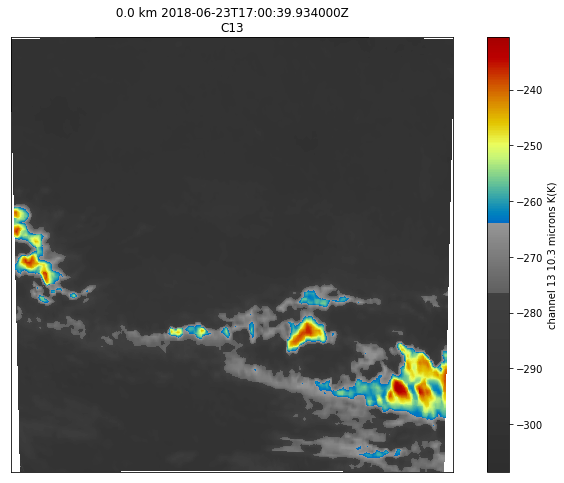

In [17]:
fig = plt.figure(figsize=[12,8])
display.plot_grid('c13', cmap = mymap)
plt.show()

In [18]:
radar = pyart.io.read_grid('/home/jhemedinger/suli_projects/precipitation-onset/grids/OR_ABI-L2-MCMIPM1-M3_G16_s20181741700341_e20181741700399_c20181741700473_grid.nc')

In [19]:
display = pyart.graph.GridMapDisplay(radar)

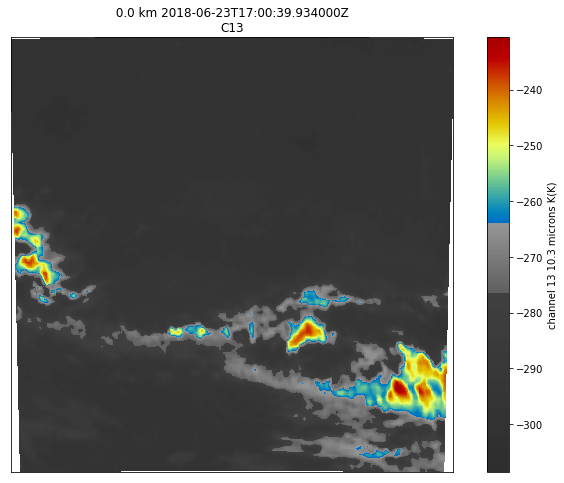

In [20]:
fig = plt.figure(figsize=[12,8])
display.plot_grid('c13', cmap = mymap)
plt.show()

In [23]:
radar.origin_longitude

{'long_name': 'Longitude at grid origin',
 'units': 'degrees_east',
 'standard_name': 'longitude',
 'valid_max': 180.0,
 'valid_min': -180.0,
 'data': masked_array(data=[-98.128],
              mask=False,
        fill_value=1e+20)}

In [25]:
radar.radar_longitude

In [24]:
example_grid.origin_longitude

{'long_name': 'Longitude at grid origin',
 'units': 'degrees_east',
 'standard_name': 'longitude',
 'valid_min': -180.0,
 'valid_max': 180.0,
 'data': masked_array(data=[-98.12771606],
              mask=False,
        fill_value=1e+20)}

In [26]:
grid.radar_longitude

<xarray.DataArray 'radar_longitude' (nradar: 1)>
array([-98.127716])
Dimensions without coordinates: nradar
Attributes:
    long_name:      Longitude at grid origin
    units:          degrees_east
    standard_name:  longitude
    valid_min:      -180.0
    valid_max:      180.0